# 패널티 선형 모델

- 선형모델의 비용함수는 RSS(잔차제곱합)을 최소화하는, 즉 실제값과 예측값의 차이의 최소화만을 고려했다
- 따라서 Train set에 지나치게 과적합되어 회귀계수가 지나치게 커지는 문제가 발생하게 된다.
- 이를 방지하기 위해 잔차 제곱합이 최소화하는 최소자승법에 패널티항을 추가하여 최소가 되는 회귀계수를 추정하는 것이 규제 회귀모델이다.
- 즉, 지나치게 많은 독립변수를 갖는 모델에 패널티를 부과함으로써 변수의 영향력을 축소 혹은 제거하여 간단한 회귀모형 구축

--------------------------------------------------------------
* 비용함수 : $RSS(W) + alpha×||W||22$
--------------------------------------------------------------

- 이처럼 잔차제곱합에 가중치를 부여하는 비용함수를 목표로 한다.
- alpha = 0인 경우 비용함수 : $Min(RSS(W))$ 
- alpha = 무한대인 경우 비용함수 : $RSS(W) + alpha×||W||22$ // 이때 $alpha×||W||22$ 의 값도 무한대가 된다.
- 즉, alpha 값이 커질 경우 회귀계수 W를 작게하여 과적합을 개선할 수 있으며, 작은 경우에는 W의 값이 조금 커져도 어느 정도 상쇄가 가능하다.
- 따라서 alpha 값을 0부터 증가시키면서 회귀계수의 크기를 감소시켜 과적합을 개선할 수 있는 방식을 규제라고 한다.

## 패널티 선형 모델 적용을 위한 보스턴 주택 가격 회귀 구현

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
boston=load_boston()
df=pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price']=boston.target
print('boston data shape :', df.shape)
df.head()

boston data shape : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- 데이터의 null 값은 존재하지 않으며 모두 실수형 자료이다.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  Price    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


### 각 컬럼별 회귀 결과에 미치는 영향 시각화

#### RM과 LSTAT가 PRICE와의 관계가 가장 큰 것을 알 수 있다.

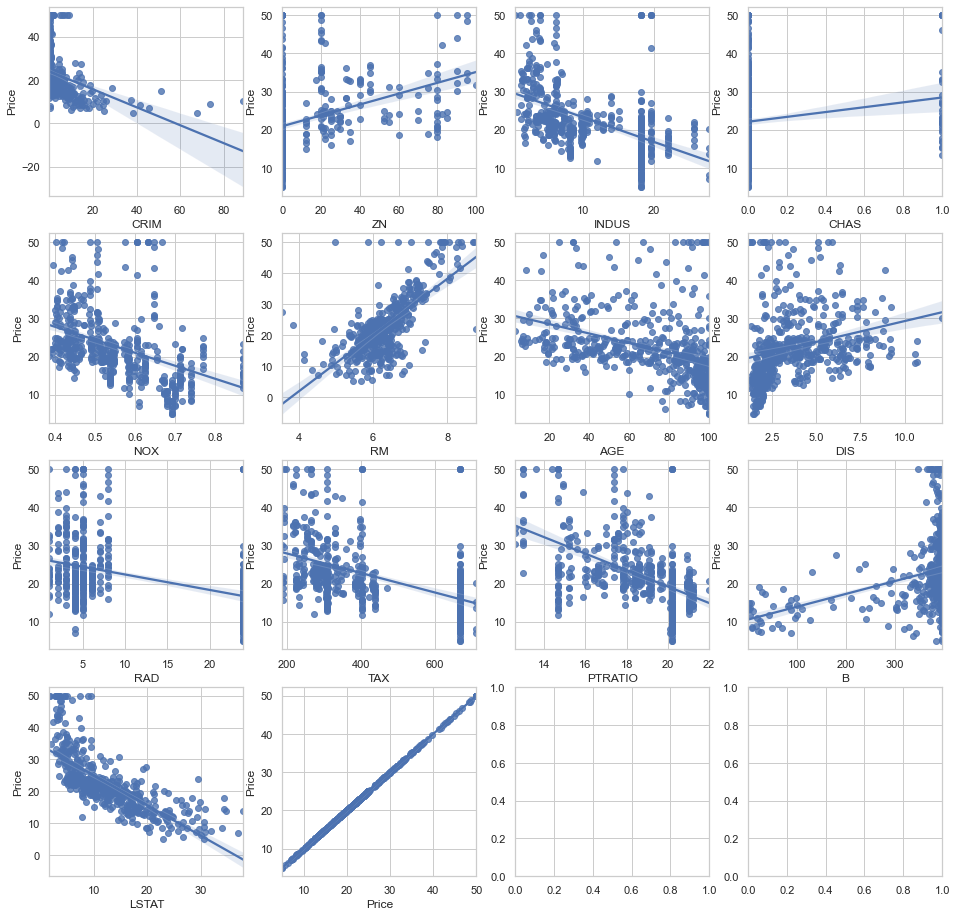

In [13]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
lm_features = df.columns

for i, features in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(features, 'Price', data=df, ax=axes[row][col])

In [14]:
X = df.drop(['Price'],axis=1,inplace=False)  # inplace를 True로 줄 경우 df의 Price 컬럼이 사라진다.
y= df.Price

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=156)
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

y_pred=lr_model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)


print('MSE : {0:.3f}'.format(mse))
print('RMSE : {0:.3f}'.format(rmse))
print('MAE : {0:.3f}'.format(mae))
print('R2_score : {0:.3f}'.format(r2))

MSE : 17.297
RMSE : 4.159
MAE : 3.214
R2_score : 0.757


### 회귀 방정식 추정

In [15]:
print('절편 값 :', lr_model.intercept_)
print('-'*40)
print('회귀 계수 값')
coef_df = pd.DataFrame(lr_model.coef_, index=X_train.columns,columns=['coef'])
coef_df.sort_values(by=['coef'],ascending=False)


절편 값 : 40.995595172164336
----------------------------------------
회귀 계수 값


,coef
RM,3.354969
CHAS,3.045898
RAD,0.355884
ZN,0.065512
INDUS,0.034437
B,0.010397
AGE,0.005937
TAX,-0.014295
CRIM,-0.112980
LSTAT,-0.566182


### 교차검증

#### cross_val_score

In [16]:
# cross_val_score을 사용하여 5폴드 교차검증 시행. 평가지표를 mse로 사용함.
# scoring 함수 적용 값 : mse = neg_mean_squared_error / mae = neg_mean_absolute_error / r2 = r2

neg_mse_score = cross_val_score(lr_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mse_score = np.mean(-1*neg_mse_score)
rmse_score = np.mean(np.sqrt(-1 * neg_mse_score))         
mae_score = np.mean(-1*cross_val_score(lr_model, X_train, y_train, scoring ='neg_mean_absolute_error', cv=5))

 # scoreing 함수는 -를 붙여서 출력한다. 따라서 -1 * 를 적용해야 한다.
print('개별 MSE :', np.round(neg_mse_score,3))
print('평균 MSE : {0:.3f}'.format(mse_score))
print('평균 RMSE : {0:.3f}'.format(rmse_score))
print('평균 MAE :', np.round(mae_score))

개별 MSE : [-37.03  -20.277 -37.547 -26.637 -15.487]
평균 MSE : 27.396
평균 RMSE : 5.162
평균 MAE : 4.0


#### cross_validate

In [17]:
score= cross_validate(lr_model, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
mse_score_2 = -1*score['test_neg_mean_squared_error']
rmse_score_2 = np.sqrt(mse_score_2)
mae_score_2 = -1*score['test_neg_mean_absolute_error']
r2_score_2 = score['test_r2']

# 평균화
mse_score_2 = np.mean(mse_score_2)
rmse_score_2 =np.mean(rmse_score_2)
mae_score_2 = np.mean(mae_score_2)
r2_score_2 = np.mean(r2_score_2)

print('MSE :',np.round(mse_score_2,3))
print('RMSE :',np.round(rmse_score_2,3))
print('MAE :',np.round(mae_score_2,3))
print('R2 :',np.round(r2_score_2,3))


MSE : 27.396
RMSE : 5.162
MAE : 3.691
R2 : 0.685


# 1. Ridge Regression

- 릿지 회귀는 L1-norm 방식을 사용하며 이는 W의 제곱에 대해 패널티를 부여하는 방식
- 모델의 설명력에 기여하지 못하는 독립변수의 회귀계수를 0에 근접하도록 축소
- 패널티의 크기는 λ로 조정한다.
- λ가 증가할수록 회귀계수는 점차 작아짐.

-----------------------------------------------------------
- 비용함수 : w = arg min(W) (∑e2i + λ∑w^2j)
-----------------------------------------------------------

- 변수 간 상관관계가 높은 상황에서 좋은 예측 성능을 보임.
- 크기가 큰 변수를 우선적으로 줄이는 경향이 있음.
- 독립변수 척도에 영향을 받기 때문에 정규화가 필요하다.

In [18]:
# modeling

rid_1 = Ridge(alpha=0.1, random_state=156)
rid_1.fit(X_train,y_train)
rid_1_y_pred = rid_1.predict(X_test)

rid_2 = Ridge(alpha=100, random_state=156)
rid_2.fit(X_train, y_train)
rid_2_y_pred = rid_2.predict(X_test)

#------------------------------------------------------------------------
# score

rid_1_mse = mean_squared_error(y_test, rid_1_y_pred)
rid_1_rmse = np.sqrt(rid_1_mse)
rid_1_mae = mean_absolute_error(y_test, rid_1_y_pred)
rid_1_r2 = r2_score(y_test, rid_1_y_pred)

rid_2_mse = mean_squared_error(y_test, rid_2_y_pred)
rid_2_rmse = np.sqrt(rid_2_mse)
rid_2_mae = mean_absolute_error(y_test, rid_2_y_pred)
rid_2_r2 = r2_score(y_test, rid_2_y_pred)
#------------------------------------------------------------------------
# 5-fold cross-validation

fold_score_1 = cross_validate(rid_1, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
rid_1_fold_mse = -fold_score_1['test_neg_mean_squared_error']
rid_1_fold_rmse = np.sqrt(rid_1_fold_mse)
rid_1_fold_mae = -fold_score_1['test_neg_mean_squared_error']
rid_1_fold_r2 = fold_score_1['test_r2']

fold_score_2 = cross_validate(rid_2, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
rid_2_fold_mse = -fold_score_2['test_neg_mean_squared_error']
rid_2_fold_rmse = np.sqrt(rid_1_fold_mse)
rid_2_fold_mae = -fold_score_2['test_neg_mean_squared_error']
rid_2_fold_r2 = fold_score_2['test_r2']

#------------------------------------------------------------------------
# 결과 출력

print('='*40)
print('normal validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(rid_1_mse,3))
print(np.round(rid_1_rmse,3))
print(np.round(rid_1_mae,3))
print(np.round(rid_1_r2,3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(rid_2_mse,3))
print(np.round(rid_2_rmse,3))
print(np.round(rid_2_mae,3))
print(np.round(rid_2_r2,3))

print('\n')
print('='*40)
print('k-fold validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(np.mean(rid_1_fold_mse),3))
print(np.round(np.mean(rid_1_fold_rmse),3))
print(np.round(np.mean(rid_1_fold_mae),3))
print(np.round(np.mean(rid_1_fold_r2),3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(np.mean(rid_2_fold_mse),3))
print(np.round(np.mean(rid_2_fold_rmse),3))
print(np.round(np.mean(rid_2_fold_mae),3))
print(np.round(np.mean(rid_2_fold_r2),3))

normal validation
Alpha가 0.1일 경우 Score
--------------------
17.244
4.153
3.203
0.758

Alpha가 100일 경우 Score
--------------------
19.362
4.4
3.346
0.728


k-fold validation
Alpha가 0.1일 경우 Score
--------------------
27.422
5.165
27.422
0.684

Alpha가 100일 경우 Score
--------------------
29.42
5.165
29.42
0.661


### 최적 하이퍼파라미터 추정

    - 0.1이 가장 우수한 성능을 보인다.

In [19]:
parameter = np.arange(0.1,10,0.1)
parameter = {'alpha' : list(np.round(parameter,3))}
ridge_model = Ridge()

rid_grid_model = GridSearchCV(ridge_model, param_grid=parameter, cv=5, refit=True)
rid_grid_model.fit(X_train,y_train)
display(pd.DataFrame(rid_grid_model.cv_results_))
print(rid_grid_model.best_params_)
print(rid_grid_model.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003788,2.130540e-03,0.002194,0.000399,0.1,{'alpha': 0.1},0.493204,0.733988,0.610402,0.746511,0.838376,0.684496,0.120047,1
1,0.002792,4.001618e-04,0.001995,0.000630,0.2,{'alpha': 0.2},0.491099,0.733632,0.610229,0.747616,0.836967,0.683909,0.120468,2
2,0.001795,3.988269e-04,0.001197,0.000399,0.3,{'alpha': 0.3},0.489212,0.733098,0.609918,0.748348,0.835691,0.683253,0.120822,3
3,0.002593,4.890255e-04,0.001796,0.000399,0.4,{'alpha': 0.4},0.487519,0.732482,0.609549,0.748838,0.834536,0.682585,0.121122,4
4,0.001795,3.989458e-04,0.001596,0.000489,0.5,{'alpha': 0.5},0.485997,0.731834,0.609164,0.749166,0.833489,0.681930,0.121380,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.002394,4.883442e-04,0.001596,0.000489,9.5,{'alpha': 9.5},0.463882,0.715130,0.611018,0.747950,0.815874,0.670771,0.122762,95
95,0.001995,8.313940e-07,0.001197,0.000399,9.6,{'alpha': 9.6},0.463843,0.715066,0.611105,0.747931,0.815821,0.670753,0.122747,96
96,0.002194,3.986121e-04,0.001596,0.000489,9.7,{'alpha': 9.7},0.463804,0.715003,0.611192,0.747912,0.815769,0.670736,0.122733,97
97,0.002394,1.017140e-03,0.001795,0.000399,9.8,{'alpha': 9.8},0.463767,0.714940,0.611279,0.747893,0.815717,0.670719,0.122718,98


{'alpha': 0.1}
0.6844961234370242


# 2. Lasso Regression

- 라쏘 회귀는 L2-norm 방식을 사용하며 이는 W의 절대값에 대해 패널티를 부여하는 방식
- 모델의 설명력에 기여하지 못하는 독립변수의 회귀계수를 0으로 만들어 제거
- 패널티의 크기는 λ로 조정한다.

----------------------------------------------------
* 비용함수 : w = argmin(w)(∑e2i + λ∑|wj|)
----------------------------------------------------

- 변수 간 상관관계가 큰 경우 예측에 영향이 생길 수 있다.

In [20]:
# modeling

las_1 = Lasso(alpha=0.1, random_state=156)
las_1.fit(X_train,y_train)
las_1_y_pred = las_1.predict(X_test)

las_2 = Lasso(alpha=100, random_state=156)
las_2.fit(X_train, y_train)
las_2_y_pred = las_2.predict(X_test)

#------------------------------------------------------------------------
# score

las_1_mse = mean_squared_error(y_test, las_1_y_pred)
las_1_r2 = r2_score(y_test, las_1_y_pred)

las_2_mse = mean_squared_error(y_test, las_2_y_pred)
las_2_r2 = r2_score(y_test, las_2_y_pred)
#------------------------------------------------------------------------
# 5-fold cross-validation

las_fold_score_1 = cross_validate(las_1, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
las_1_fold_mse = -las_fold_score_1['test_neg_mean_squared_error']
las_1_fold_r2 = las_fold_score_1['test_r2']

las_fold_score_2 = cross_validate(las_2, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
las_2_fold_mse = -las_fold_score_2['test_neg_mean_squared_error']
las_2_fold_r2 = las_fold_score_2['test_r2']

#------------------------------------------------------------------------
# 결과 출력

print('='*40)
print('normal validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(las_1_mse,3))
print(np.round(las_1_r2,3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(las_2_mse,3))
print(np.round(las_2_r2,3))

print('\n')
print('='*40)
print('k-fold validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(np.mean(las_1_fold_mse),3))
print(np.round(np.mean(las_1_fold_r2),3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(np.mean(las_2_fold_mse),3))
print(np.round(np.mean(las_2_fold_r2),3))

normal validation
Alpha가 0.1일 경우 Score
--------------------
17.829
0.75

Alpha가 100일 경우 Score
--------------------
49.38
0.307


k-fold validation
Alpha가 0.1일 경우 Score
--------------------
29.121
0.664

Alpha가 100일 경우 Score
--------------------
73.863
0.166


### 최적 하이퍼파라미터 추정

    - 0.2가 가장 우수한 성능을 보인다.

In [21]:
parameter = np.arange(0.1,10,0.1)
parameter = {'alpha' : parameter}
lasso_model = Lasso()

las_grid_model = GridSearchCV(lasso_model, param_grid=parameter,refit=True, cv=5)
las_grid_model.fit(X_train,y_train)
display(pd.DataFrame(las_grid_model.cv_results_))
print(las_grid_model.best_params_)
print(las_grid_model.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003401,1.492354e-03,0.001792,1.155746e-03,0.1,{'alpha': 0.1},0.445754,0.713547,0.606246,0.747146,0.806162,0.663771,0.126921,2
1,0.002380,8.060354e-04,0.001606,4.852554e-04,0.2,{'alpha': 0.2},0.446474,0.709352,0.614089,0.747856,0.802135,0.663981,0.124883,1
2,0.003384,7.921859e-04,0.002194,7.464040e-04,0.3,{'alpha': 0.30000000000000004},0.446332,0.708218,0.618456,0.743715,0.800219,0.663388,0.123545,3
3,0.002194,3.989697e-04,0.001994,3.234067e-07,0.4,{'alpha': 0.4},0.445082,0.706257,0.621579,0.736259,0.797311,0.661298,0.122038,4
4,0.002394,4.885583e-04,0.001396,4.886750e-04,0.5,{'alpha': 0.5},0.442718,0.703595,0.623316,0.728155,0.793510,0.658259,0.120758,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.001988,1.244207e-05,0.001197,3.990656e-04,9.5,{'alpha': 9.5},0.323625,0.553277,0.491939,0.568121,0.596503,0.506693,0.097715,95
95,0.002194,3.988267e-04,0.001197,3.987074e-04,9.6,{'alpha': 9.6},0.323326,0.552054,0.491018,0.566948,0.595726,0.505815,0.097448,96
96,0.001795,3.988982e-04,0.001596,4.884998e-04,9.7,{'alpha': 9.700000000000001},0.323004,0.550820,0.490093,0.565766,0.594942,0.504925,0.097187,97
97,0.001995,3.162980e-07,0.001596,4.884998e-04,9.8,{'alpha': 9.8},0.322659,0.549574,0.489162,0.564576,0.594153,0.504025,0.096932,98


{'alpha': 0.2}
0.6639811696844847


# 3. ElasticNet Regression

- L1과 L2 모두를 이용하여 모델에 패널티를 부과하는 방식
- Ridge와 Lasso의 결합 형태로 회귀계수를 축소하거나 제거할 수 있음.
- alpha값을 (1-a)(|b1| + |b2|) + a(b1^2+b2^2) 형태로 통제할 수 있다.

----------------------------------------------------
* 비용함수 : w = argmin(w)(∑e2i + λ1∑|wj| + λ2∑w^2j)
----------------------------------------------------

In [22]:
# modeling

ela_1 = ElasticNet(alpha=0.1, random_state=156)
ela_1.fit(X_train,y_train)
ela_1_y_pred = ela_1.predict(X_test)

ela_2 = ElasticNet(alpha=100, random_state=156)
ela_2.fit(X_train, y_train)
ela_2_y_pred = ela_2.predict(X_test)

#------------------------------------------------------------------------
# score

ela_1_mse = mean_squared_error(y_test, ela_1_y_pred)
ela_1_r2 = r2_score(y_test, ela_1_y_pred)

ela_2_mse = mean_squared_error(y_test, ela_2_y_pred)
ela_2_r2 = r2_score(y_test, ela_2_y_pred)
#------------------------------------------------------------------------
# 5-fold cross-validation

ela_fold_score_1 = cross_validate(las_1, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
ela_1_fold_mse = -ela_fold_score_1['test_neg_mean_squared_error']
ela_1_fold_r2 = ela_fold_score_1['test_r2']

ela_fold_score_2 = cross_validate(las_2, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
ela_2_fold_mse = -ela_fold_score_2['test_neg_mean_squared_error']
ela_2_fold_r2 = ela_fold_score_2['test_r2']

#------------------------------------------------------------------------
# 결과 출력

print('='*40)
print('normal validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(ela_1_mse,3))
print(np.round(ela_1_r2,3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(ela_2_mse,3))
print(np.round(ela_2_r2,3))

print('\n')
print('='*40)
print('k-fold validation')
print('='*40)
print('Alpha가 0.1일 경우 Score')
print('-'*20)
print(np.round(np.mean(ela_1_fold_mse),3))
print(np.round(np.mean(ela_1_fold_r2),3))

print('\nAlpha가 100일 경우 Score')
print('-'*20)
print(np.round(np.mean(ela_2_fold_mse),3))
print(np.round(np.mean(ela_2_fold_r2),3))

normal validation
Alpha가 0.1일 경우 Score
--------------------
18.117
0.746

Alpha가 100일 경우 Score
--------------------
48.032
0.326


k-fold validation
Alpha가 0.1일 경우 Score
--------------------
29.121
0.664

Alpha가 100일 경우 Score
--------------------
73.863
0.166


### 최적 하이퍼파라미터 추정

    - 0.1이 가장 우수한 성능을 보인다.

In [23]:
elasticnet_model = ElasticNet()

ela_grid_model = GridSearchCV(elasticnet_model, param_grid=parameter, cv=5, refit=True)
ela_grid_model.fit(X_train,y_train)
display(pd.DataFrame(ela_grid_model.cv_results_))
print(ela_grid_model.best_params_)
print(ela_grid_model.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002798,0.000736,0.001400,0.000486,0.1,{'alpha': 0.1},0.455087,0.709758,0.616516,0.745529,0.808696,0.667117,0.122905,1
1,0.002000,0.000015,0.001391,0.000481,0.2,{'alpha': 0.2},0.451277,0.704094,0.625064,0.740130,0.802642,0.664641,0.121153,2
2,0.001809,0.000405,0.001383,0.000474,0.3,{'alpha': 0.30000000000000004},0.449927,0.699687,0.629019,0.734622,0.797599,0.662171,0.119285,3
3,0.001987,0.000014,0.001006,0.000013,0.4,{'alpha': 0.4},0.447240,0.696090,0.630403,0.729501,0.793555,0.659358,0.118415,4
4,0.001795,0.000399,0.001195,0.000384,0.5,{'alpha': 0.5},0.443953,0.693394,0.630657,0.724829,0.789423,0.656451,0.117934,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.001603,0.000493,0.001193,0.000384,9.5,{'alpha': 9.5},0.324065,0.573315,0.508979,0.591091,0.618141,0.523118,0.105822,95
95,0.001791,0.000400,0.001206,0.000395,9.6,{'alpha': 9.6},0.324194,0.572628,0.508414,0.590442,0.617738,0.522683,0.105568,96
96,0.001793,0.000397,0.001192,0.000389,9.7,{'alpha': 9.700000000000001},0.324313,0.571938,0.507849,0.589791,0.617333,0.522245,0.105316,97
97,0.001590,0.000482,0.001197,0.000398,9.8,{'alpha': 9.8},0.324422,0.571244,0.507282,0.589137,0.616925,0.521802,0.105068,98


{'alpha': 0.1}
0.6671172127375702


In [24]:
ela_grid_model.best_params_['alpha']

0.1

# 위 과정을 한번에 수행

In [25]:
# alpha 값(parameter) 세팅
parameter = {'alpha' : np.arange(0.1,10,0.1)}

ridge_model = Ridge()
lasso_model = Lasso()
elasticnet_model = ElasticNet()

ridge_grid = GridSearchCV(ridge_model, param_grid=parameter, cv=5, refit=True)
ridge_grid.fit(X_train,y_train)
lasso_grid = GridSearchCV(lasso_model, param_grid=parameter, cv=5, refit=True)
lasso_grid.fit(X_train,y_train)
elasticnet_grid = GridSearchCV(elasticnet_model, param_grid=parameter, cv=5, refit=True)
elasticnet_grid.fit(X_train,y_train)

print('ridge 최적 파라미터 :',ridge_grid.best_params_)
print('lasso 최적 파라미터 :',lasso_grid.best_params_)
print('elasticnet 최적 파라미터 :',elasticnet_grid.best_params_)

ridge 최적 파라미터 : {'alpha': 0.1}
lasso 최적 파라미터 : {'alpha': 0.2}
elasticnet 최적 파라미터 : {'alpha': 0.1}


In [26]:
ridge_model = Ridge(alpha=0.1, random_state = 156)
lasso_model = Lasso(alpha=0.2, random_state = 156)
elasticnet_model = ElasticNet(alpha=0.1, random_state = 156)

score= cross_validate(ridge_model, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
ridge_mse = np.mean(-1*score['test_neg_mean_squared_error'])
ridge_rmse = np.mean(np.sqrt(mse_score_2))
ridge_r2= np.mean(score['test_r2'])

score= cross_validate(lasso_model, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
lasso_mse = np.mean(-1*score['test_neg_mean_squared_error'])
lasso_rmse = np.mean(np.sqrt(mse_score_2))
lasso_r2= np.mean(score['test_r2'])

score= cross_validate(elasticnet_model, X_train, y_train, scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2'], cv=5)
elasticnet_mse = np.mean(-1*score['test_neg_mean_squared_error'])
elasticnet_rmse = np.mean(np.sqrt(mse_score_2))
elasticnet_r2= np.mean(score['test_r2'])



print('Ridge_MSE :',np.round(ridge_mse,3))
print('Ridge_RMSE :',np.round(ridge_rmse,3))
print('Ridge_R2 :',np.round(ridge_r2,3))
print('-'*40)
print('Lasso_MSE :',np.round(lasso_mse,3))
print('Lasso_RMSE :',np.round(lasso_rmse,3))
print('Lasso_R2 :',np.round(lasso_r2,3))
print('-'*40)
print('Elasticnet_MSE :',np.round(elasticnet_mse,3))
print('Elasticnet_RMSE :',np.round(elasticnet_rmse,3))
print('Elasticnet_R2 :',np.round(elasticnet_r2,3))

Ridge_MSE : 27.422
Ridge_RMSE : 5.234
Ridge_R2 : 0.684
----------------------------------------
Lasso_MSE : 29.086
Lasso_RMSE : 5.234
Lasso_R2 : 0.664
----------------------------------------
Elasticnet_MSE : 28.828
Elasticnet_RMSE : 5.234
Elasticnet_R2 : 0.667


# 최종 모델학습 및 예측결과 ploting

In [27]:
ridge_model = Ridge(alpha=0.1, random_state = 156)
ridge_model.fit(X_train,y_train)
train_y_pred = ridge_model.predict(X_train)
y_pred = ridge_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_y_pred)) 
train_mse = mean_squared_error(y_train, train_y_pred)
train_r2 = r2_score(y_train, train_y_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print('Train rmse :{:.3f}'.format(train_rmse))
print('Train mse :{:.3f}'.format(train_mse))
print('Train R2 :{:.3f}'.format(train_r2))
print('='*40)
print('Test rmse :{:.3f}'.format(test_rmse))
print('Test mse :{:.3f}'.format(test_mse))
print('Test R2 :{:.3f}'.format(test_r2))

Train rmse :4.944
Train mse :24.438
Train R2 :0.727
Test rmse :4.153
Test mse :17.244
Test R2 :0.758


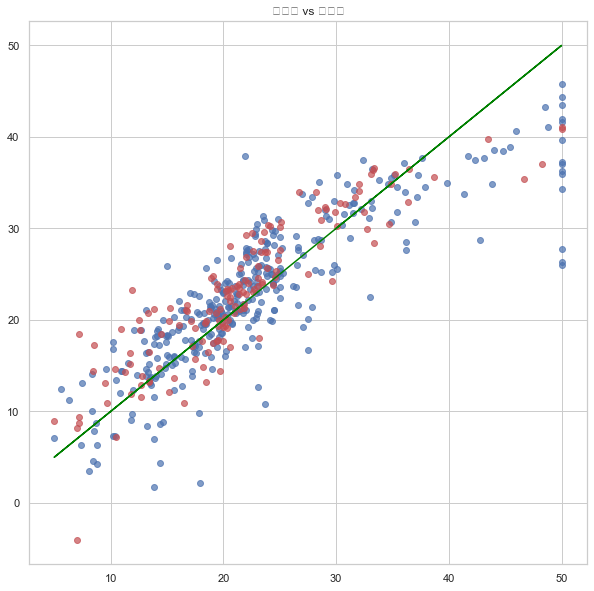

In [28]:
plt.figure(figsize=(10,10))
plt.title('실제값 vs 예측값')
plt.plot(y_test,y_test,c='green')
plt.scatter(y_train,train_y_pred, alpha=0.7,c='b')
plt.scatter(y_test,y_pred, alpha=0.7,c='r')

# 잔차검정

### 선형성 및 등분산성

<AxesSubplot:ylabel='Price'>

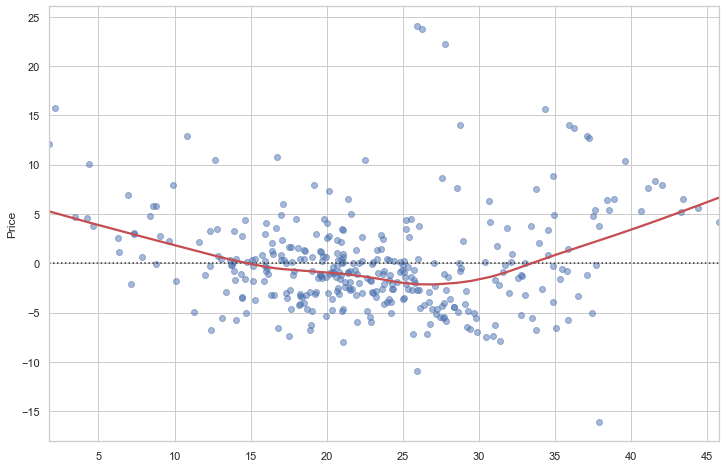

In [30]:
train_resid = y_train - train_y_pred

plt.figure(figsize=(12,8))
sns.residplot(train_y_pred,y_train, lowess=True, line_kws={'color':'r'}, scatter_kws={'alpha':0.5})

### 정규성

<AxesSubplot:xlabel='Price', ylabel='Density'>

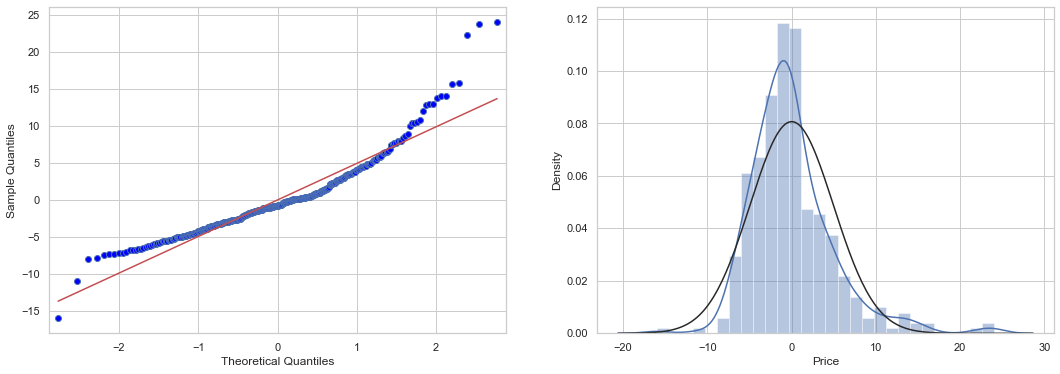

In [31]:
from scipy.stats import norm

plt.figure(figsize=(18,6))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
sm.qqplot(train_resid, line='s', ax=ax1)
sns.distplot(train_resid, fit=norm, ax=ax2)